LSE Data Science Institute | DISCORDIA project

# Scraping House of Commons debates


**LAST UPDATED:** 5 December 2023

**AUTHORS:** [@jonjoncardoso](https://jonjoncardoso.github.io)

**TODO list:**

- [x] Freely explore the debates (using the current dataset with debates from 1 Jan 2023 to 30 Nov 2023)
- [x] Explore: are there cases of dissent in the current dataset? 

---

# ⚙️ SETUP

## Imports

In [6]:
import os
import re
import sys
import sqlalchemy

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
from selenium import webdriver

from sqlalchemy import create_engine

%matplotlib inline
from plotnine import *
from mizani.formatters import percent_format

In [7]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0,'../src/python/')

# https://stackoverflow.com/questions/70898150/jupyter-autoreload-workflow/73623267#73623267

%aimport discordia
%aimport discordia.webscraping.twfy
%aimport discordia.webscraping.utils

#from discordia.webscraping.utils import print_HTML, show_HTML
from discordia.webscraping.twfy import build_url, scrape_debate_sections, get_speeches_divisions_and_votes
from discordia.webscraping.utils import print_HTML, show_HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%load_ext sql
%config SqlMagic.autocommit=True # for engines that do not support autommit
%config SqlMagic.displaylimit = None

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


displaylimit: Value None will be treated as 0 (no limit)

## Connect to SQLite database

In [9]:
# Create a database engine using SQLAlchemy
engine = create_engine('sqlite:///../../data/discordia.db', echo=False, isolation_level="AUTOCOMMIT")

# Why? Read: https://stackoverflow.com/a/71685414/843365
with engine.connect() as conn:
    pass


In [10]:
%sql sqlite:///../../data/discordia.db --alias discordia

Connecting to 'discordia'

# Part 1: Dissent

I selected a random house_division_id to investigate

In [142]:
%%sql discordia --save summary_votes

SELECT 
    mp.party,
    CASE votes.is_vote_aye WHEN 1 THEN 'aye' ELSE 'no' END AS vote,
    COUNT(*) AS num_votes,
    SUM(votes.is_teller) AS num_tellers
FROM
    votes
LEFT JOIN
    mp
ON
    votes.mp_id = mp.mp_id
WHERE 
    house_division_id = 'g613.0' AND
    mp.term_start = 2017
GROUP BY
    mp.party, votes.is_teller, votes.is_vote_aye
ORDER BY
    party, vote, num_votes DESC


party,vote,num_votes,num_tellers
Alliance,aye,1,0
Conservative,aye,1,0
Conservative,no,300,0
Conservative,no,2,2
Green,aye,1,0
Independent,aye,8,0
Independent,no,3,0
Labour,aye,141,0
Labour,aye,2,2
Labour/Co-operative,aye,14,0


In [177]:
%%sql discordia

SELECT 
    A.party,
    IFNULL(CAST(A.total_ayes - A.total_tellers AS TEXT) || CASE A.total_tellers WHEN 0 THEN '' ELSE char(10) || ' (+' || A.total_tellers || ' tellers)' END, 0) AS aye,
    IFNULL(CAST(B.total_nos - B.total_tellers AS TEXT) || CASE B.total_tellers WHEN 0 THEN '' ELSE char(10) || ' (+' || B.total_tellers || ' tellers)' END, 0) AS no
FROM 
    (SELECT 
         party, 
         sum(num_votes) as total_ayes, 
         sum(num_tellers) as total_tellers 
     FROM 
         summary_votes 
     WHERE 
         vote = 'aye' 
     GROUP BY 
         party) A 
LEFT OUTER JOIN 
    (SELECT 
         party, 
         sum(num_votes) as total_nos, 
         sum(num_tellers) as total_tellers 
     FROM 
         summary_votes 
     WHERE 
         vote = 'no' 
     GROUP BY 
         party) B 
ON 
    A.party = B.party

Generating CTE with stored snippets: 'summary_votes', and 'summary_votes'

party,aye,no
Alliance,1,0
Conservative,1,300 (+2 tellers)
Green,1,0
Independent,8,3
Labour,141 (+2 tellers),0
Labour/Co-operative,14,0
Plaid Cymru,2,0
Scottish National Party,25,0
Social Democratic and Labour Party,2,0


💡 TAKEAWAYS:

- On the example above, there was apparently 1 Tory MP who voted against their party
- I am curious about the Independent MPs. Are they really independent? Or are they just MPs who left their parties?

## 1.1 What was this vote about and who was the Tory dissenters?

In [178]:
%%sql discordia

SELECT 
    *
FROM
    house_divisions
WHERE
    house_division_id = 'g613.0'

debate_id,house_division_id,vote_title
2023-01-11e.566.1,g613.0,Fair Taxation of Schools and Education Standards Committee


Who amongst the Conservatives voted 'aye'?

In [181]:
%%sql discordia

SELECT 
     mp.*
    FROM
        votes
    LEFT JOIN
        mp
    ON
        votes.mp_id = mp.mp_id
    WHERE
        house_division_id = 'g613.0' AND
        mp.term_start = 2017 AND
        mp.party = 'Conservative' AND
        votes.is_vote_aye = 1

mp_id,first_name,last_name,party,constituency,url,term_start,term_end
25276,Lisa,Cameron,Conservative,"East Kilbride, Strathaven and Lesmahagow",https://www.theyworkforyou.com/mp/25276/lisa_cameron/east_kilbride%2C_strathaven_and_lesmahagow,2017,2023


# Part 2: The story of Lisa Cameron

💡 Lisa Cameron has already defected from SNP to Conservatives: https://www.bbc.co.uk/news/uk-scotland-scotland-politics-67137177


In [183]:
%%sql discordia

SELECT 
    *
FROM
    mp
WHERE mp_id = "25276"

mp_id,first_name,last_name,party,constituency,url,term_start,term_end
25276,Lisa,Cameron,Scottish National Party,"East Kilbride, Strathaven and Lesmahagow",https://www.theyworkforyou.com/mp/25276/lisa_cameron/east_kilbride%2C_strathaven_and_lesmahagow,2010,1015
25276,Lisa,Cameron,Scottish National Party,"East Kilbride, Strathaven and Lesmahagow",https://www.theyworkforyou.com/mp/25276/lisa_cameron/east_kilbride%2C_strathaven_and_lesmahagow,2015,2017
25276,Lisa,Cameron,Conservative,"East Kilbride, Strathaven and Lesmahagow",https://www.theyworkforyou.com/mp/25276/lisa_cameron/east_kilbride%2C_strathaven_and_lesmahagow,2017,2023


## 2.1 Lisa Cameron's voting record

Is she always a dissenter?

In [124]:
%%sql discordia

SELECT 
    house_divisions.debate_id,
    lisa.house_division_id,
    CASE WHEN lisa.is_vote_aye = 1 THEN 'aye' ELSE 'no' END AS 'How Lisa voted:',
    SUM(CASE WHEN other_mps.is_vote_aye = 1 THEN 1 ELSE 0 END) AS 'How many other Tory MPs voted aye:',
    SUM(CASE WHEN other_mps.is_vote_aye = 0 THEN 1 ELSE 0 END) AS 'How many other Tory MPs voted no:',
    CASE WHEN lisa.is_vote_aye != CASE WHEN other_mps.is_vote_aye = 1 THEN 1 ELSE 0 END THEN 'AGAINST' ELSE 'WITH ' END AS 'Was Lisa in the majority?'
FROM
    (SELECT 
        mp.party,
        votes.house_division_id,
        votes.is_vote_aye
     FROM
        votes
     LEFT JOIN
         mp
     USING(mp_id)
     WHERE votes.mp_id = "25276" AND mp.term_start == 2017) lisa
LEFT OUTER JOIN
    (SELECT
        votes.house_division_id,
        votes.is_vote_aye,
        mp.party
     FROM
        votes
     LEFT JOIN
        mp
     ON
        votes.mp_id = mp.mp_id
     WHERE votes.mp_id != "25276" AND mp.term_start == 2017) other_mps
     ON
        lisa.house_division_id = other_mps.house_division_id AND
        lisa.party = other_mps.party
LEFT JOIN
      house_divisions
USING (house_division_id)
GROUP BY
   lisa.is_vote_aye,
   house_divisions.debate_id,
   lisa.house_division_id
ORDER BY
   house_divisions.debate_id ASC

debate_id,house_division_id,How Lisa voted:,How many other Tory MPs voted aye:,How many other Tory MPs voted no:,Was Lisa in the majority?
2023-01-11e.566.1,g613.0,aye,0,302,AGAINST
2023-01-16f.139.0,g140.0,no,303,0,AGAINST
2023-01-16f.144.0,g144.2,no,301,0,AGAINST
2023-01-16f.54.0,g135.0,no,307,1,WITH
2023-01-16f.54.0,g131.5,aye,1,298,AGAINST
2023-01-17c.228.0,g262.0,no,310,0,AGAINST
2023-01-31b.278.0,g308.0,aye,0,297,AGAINST
2023-02-21c.193.0,g194.6,no,252,0,AGAINST
2023-02-28d.701.0,g710.0,aye,0,0,AGAINST
2023-03-13b.573.0,g647.0,no,308,0,AGAINST


## 2.2 Why is she so against her own party?

Maybe looking at her speeches can give us some clues.

Fist, I will expand on the table above to indicate whether she spoke during the debate or not.

In [125]:
%%sql discordia

SELECT 
    house_divisions.debate_id,
    lisa.house_division_id,
    COALESCE(lisa_speeches_debate.num_speeches_debate, 0) AS '# speeches in debate',
    COALESCE(lisa_speeches_day.num_speeches_day, 0) AS '# speeches in day',
    CASE WHEN lisa.is_vote_aye = 1 THEN 'aye' ELSE 'no' END AS 'How Lisa voted:',
    SUM(CASE WHEN other_mps.is_vote_aye = 1 THEN 1 ELSE 0 END) AS '# Tory MPs voted aye:',
    SUM(CASE WHEN other_mps.is_vote_aye = 0 THEN 1 ELSE 0 END) AS '# Tory MPs voted no:',
    CASE WHEN SUM(lisa.is_vote_aye != other_mps.is_vote_aye) > SUM(lisa.is_vote_aye = other_mps.is_vote_aye) THEN 'AGAINST HER PARTY' ELSE 'WITH HER PARTY' END AS 'How Lisa voted'
FROM
    (SELECT 
        mp.party,
        votes.house_division_id,
        votes.is_vote_aye
     FROM
        votes
     LEFT JOIN
         mp
     USING(mp_id)
     WHERE votes.mp_id = "25276" AND mp.term_start == 2017) lisa
LEFT OUTER JOIN
    (SELECT
        votes.house_division_id,
        votes.is_vote_aye,
        mp.party
     FROM
        votes
     LEFT JOIN
        mp
     ON
        votes.mp_id = mp.mp_id
     WHERE votes.mp_id != "25276" AND mp.term_start == 2017) other_mps
     ON
        lisa.house_division_id = other_mps.house_division_id AND
        lisa.party = other_mps.party
LEFT JOIN
      house_divisions
USING (house_division_id)
LEFT JOIN
      (
         SELECT
            speeches.debate_id,
            speeches.speaker_id AS mp_id,
            COUNT(speeches.speech_id) AS num_speeches_debate
         FROM
            speeches
         WHERE
            speeches.speaker_id = "25276"
         GROUP BY
            speeches.debate_id,
            speeches.speaker_id
      ) lisa_speeches_debate
ON
      house_divisions.debate_id = lisa_speeches_debate.debate_id
LEFT JOIN
      (
         SELECT
            SUBSTR(speeches.debate_id, 1, 10) AS debate_day,
            speeches.speaker_id AS mp_id,
            COUNT(speeches.speech_id) AS num_speeches_day
         FROM
            speeches
         WHERE
            speeches.speaker_id = "25276"
         GROUP BY
            debate_day,
            speeches.speaker_id
      ) lisa_speeches_day
ON
      SUBSTR(house_divisions.debate_id, 1, 10) = lisa_speeches_day.debate_day
GROUP BY
   lisa.is_vote_aye,
   house_divisions.debate_id,
   lisa.house_division_id
ORDER BY
   house_divisions.debate_id ASC

debate_id,house_division_id,# speeches in debate,# speeches in day,How Lisa voted:,# Tory MPs voted aye:,# Tory MPs voted no:,How Lisa voted
2023-01-11e.566.1,g613.0,0,0,aye,0,302,AGAINST HER PARTY
2023-01-16f.139.0,g140.0,0,0,no,303,0,AGAINST HER PARTY
2023-01-16f.144.0,g144.2,0,0,no,301,0,AGAINST HER PARTY
2023-01-16f.54.0,g135.0,0,0,no,307,1,AGAINST HER PARTY
2023-01-16f.54.0,g131.5,0,0,aye,1,298,AGAINST HER PARTY
2023-01-17c.228.0,g262.0,0,0,no,310,0,AGAINST HER PARTY
2023-01-31b.278.0,g308.0,0,1,aye,0,297,AGAINST HER PARTY
2023-02-21c.193.0,g194.6,0,0,no,252,0,AGAINST HER PARTY
2023-02-28d.701.0,g710.0,0,0,aye,0,0,WITH HER PARTY
2023-03-13b.573.0,g647.0,0,0,no,308,0,AGAINST HER PARTY


## 2.3 Lisa Cameron's utterances

💡 **Lisa never speaks during the debates.**

On the days where there were house divisions, she only spoke twice. Once on 2023-01-31 and once on 2023-04-25. Let's see what she said on those days.

In [269]:
%%sql lisa_speeches <<

SELECT *
FROM
    speeches
WHERE
    speaker_id = "25276"
ORDER BY 
    debate_id ASC

Running query in 'discordia'

In [271]:
lisa_speeches = lisa_speeches.DataFrame()

In [276]:
lisa_speeches['debate_day'] = lisa_speeches['debate_id'].str[:10]
lisa_speeches.set_index('debate_day', inplace=True)

### 31/01/2023: On Blockchain

In [284]:
lisa_speeches.loc[['2023-01-31']]

,debate_id,speech_id,speaker_id,speaker_position,speech_html,speech_raw_text
debate_day,,,,,,
2023-01-31,2023-01-31b.197.0,g201.2,25276,"Scottish National Party, East Kilbride, Strath...","<p pid=""b201.2/1"" qnum=""903394"">\n [R] As chai...",[R] As chair of the all-party parliamentary gr...


In [281]:
show_HTML(lisa_speeches.loc['2023-01-31']['speech_html'])

This was part of questions made to the Foreign Secretary of Foreign, Commonwealth and Development Affairs. 

In [289]:
%%sql discordia

SELECT 
    *
FROM 
    debates
WHERE  
    debate_id == '2023-01-31b.197.0'

debate_id,debate_excerpt,url,title,section,section_excerpt
2023-01-31b.197.0,If he will make a statement on his departmental responsibilities.,https://www.theyworkforyou.com/debates/?id=2023-01-31b.197.0,Topical Questions,"Foreign, Commonwealth and Development Office",The Secretary of State was asked—


The exchange that ensued and the question she got was just as empty as the question...

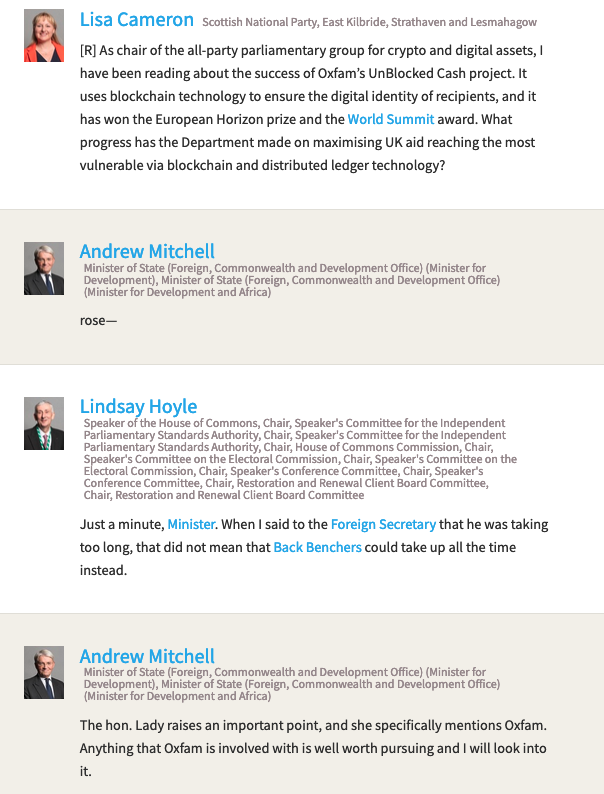

### 25/04/2023: On GP appointments

In [285]:
lisa_speeches.loc[['2023-04-25']]

,debate_id,speech_id,speaker_id,speaker_position,speech_html,speech_raw_text
debate_day,,,,,,
2023-04-25,2023-04-25c.581.1,g585.4,25276,"Scottish National Party, East Kilbride, Strath...","<p pid=""c585.4/1"" qnum=""904629"">\n As chair of...",As chair of the all-party parliamentary health...


In [286]:
show_HTML(lisa_speeches.loc['2023-04-25']['speech_html'])

This one led to a more interesting exchange, but not relevant to our research question

In [290]:
%%sql discordia

SELECT 
    *
FROM 
    debates
WHERE  
    debate_id == '2023-04-25c.581.1'

debate_id,debate_excerpt,url,title,section,section_excerpt
2023-04-25c.581.1,If he will make a statement on his departmental responsibilities.,https://www.theyworkforyou.com/debates/?id=2023-04-25c.581.1,Topical Questions,Health and Social Care,The Secretary of State was asked—


# Part 3: Rebel statistics

How do I write a query to find a rebel MP that speaks during the debates? This was a complex task so I tried to elicit help from the AI overlords, but they were not very helpful. I ended up building the query myself, step by step and only used ChatGPT to optimise the query (with a CTE).

## 3.1 What are the cases of dissent in which the 'rebel MP' spoke during the debate?

In [28]:
%%sql discordia --save mp_votes --no-execute

SELECT 
    votes.*, 
    mp.*,
    house_divisions.debate_id
FROM
    votes
INNER JOIN 
    mp USING(mp_id)
LEFT JOIN
    house_divisions
USING (house_division_id)
WHERE 
    mp.term_start = 2017

Skipping execution...

In [127]:
%%sql --save votes_and_speeches --no-execute

SELECT 
    main_mp_summary.party,
    main_mp_summary.mp_id,
    main_mp_summary.debate_id,
    main_mp_summary.house_division_id,
    voted_against_party,
    COALESCE(num_speeches_debate, 0) AS num_speeches_debate
FROM
(
    SELECT 
        main_mps.party,
        main_mps.debate_id,
        main_mps.house_division_id,
        main_mps.mp_id AS mp_id,
        CASE 
            WHEN SUM(main_mps.is_vote_aye == other_mps.is_vote_aye) < SUM(main_mps.is_vote_aye != other_mps.is_vote_aye) 
            THEN TRUE 
            ELSE FALSE 
        END AS voted_against_party
    FROM
        mp_votes main_mps
    LEFT JOIN 
        mp_votes other_mps
    ON 
        main_mps.house_division_id = other_mps.house_division_id AND 
        main_mps.mp_id != other_mps.mp_id AND 
        main_mps.party = other_mps.party
    GROUP BY
        main_mps.house_division_id,
        main_mps.mp_id
) main_mp_summary
LEFT JOIN
(
    SELECT
        speeches.speaker_id AS mp_id,
        house_divisions.debate_id,
        house_divisions.house_division_id,
        COUNT(DISTINCT speeches.speech_id) AS num_speeches_debate
    FROM
        speeches
    INNER JOIN
        house_divisions
    ON 
        speeches.debate_id = house_divisions.debate_id
    GROUP BY
        speeches.speaker_id,
        speeches.debate_id
    ORDER BY 
        speeches.debate_id ASC,
        house_divisions.house_division_id ASC
) speeches_debate
ON
    main_mp_summary.mp_id = speeches_debate.mp_id AND
    main_mp_summary.house_division_id = speeches_debate.house_division_id
ORDER BY 
    main_mp_summary.party ASC,
    main_mp_summary.mp_id ASC,
    main_mp_summary.debate_id ASC,
    main_mp_summary.house_division_id ASC


Generating CTE with stored snippets: 'mp_votes', and 'mp_votes'

Running query in 'discordia'

Skipping execution...

In [129]:
%%sql discordia

SELECT
    *
FROM
    votes_and_speeches
WHERE 
    voted_against_party = TRUE AND
    num_speeches_debate > 0

Generating CTE with stored snippets: 'votes_and_speeches'

party,mp_id,debate_id,house_division_id,voted_against_party,num_speeches_debate
Conservative,10051,2023-07-03b.586.0,g657.0,1,3
Conservative,10095,2023-03-22b.338.0,g364.0,1,5
Conservative,10095,2023-06-19b.583.0,g661.2,1,10
Conservative,10499,2023-03-22b.338.0,g364.0,1,4
Conservative,10901,2023-03-22b.338.0,g364.0,1,1
Conservative,11506,2023-03-22b.338.0,g364.0,1,1
Conservative,11599,2023-06-19b.583.0,g661.2,1,3
Conservative,24756,2023-09-12c.847.0,g869.0,1,6
Conservative,25360,2023-07-03b.586.0,g657.0,1,2
Conservative,25859,2023-06-19b.583.0,g661.2,1,3


## 3.2 Putting things into perspective 

The above reveal that this is very very rare. The summary tables and plots below aim to give a sense of how rare this is.

**Q:** How many house divisions were there in total?

In [178]:
%%sql discordia

SELECT 
    COUNT(DISTINCT house_division_id) AS num_divisions
FROM
    house_divisions


num_divisions
59


**Q:** Typically, how many MPs speak during a debate in which there is a house division?

In [41]:
%%sql speakers_per_debate <<

SELECT 
    debate_id,
    COUNT(DISTINCT speaker_id) AS num_speakers
FROM
    house_divisions
LEFT JOIN
    speeches
USING (debate_id)
GROUP BY
    debate_id

Running query in 'discordia'

In [42]:
speakers_per_debate = speakers_per_debate.DataFrame()

In [51]:
speakers_per_debate.describe()

,num_speakers
count,47.000000
mean,24.914894
std,24.060458
min,0.000000
25%,0.000000
50%,24.000000
75%,41.000000
max,84.000000


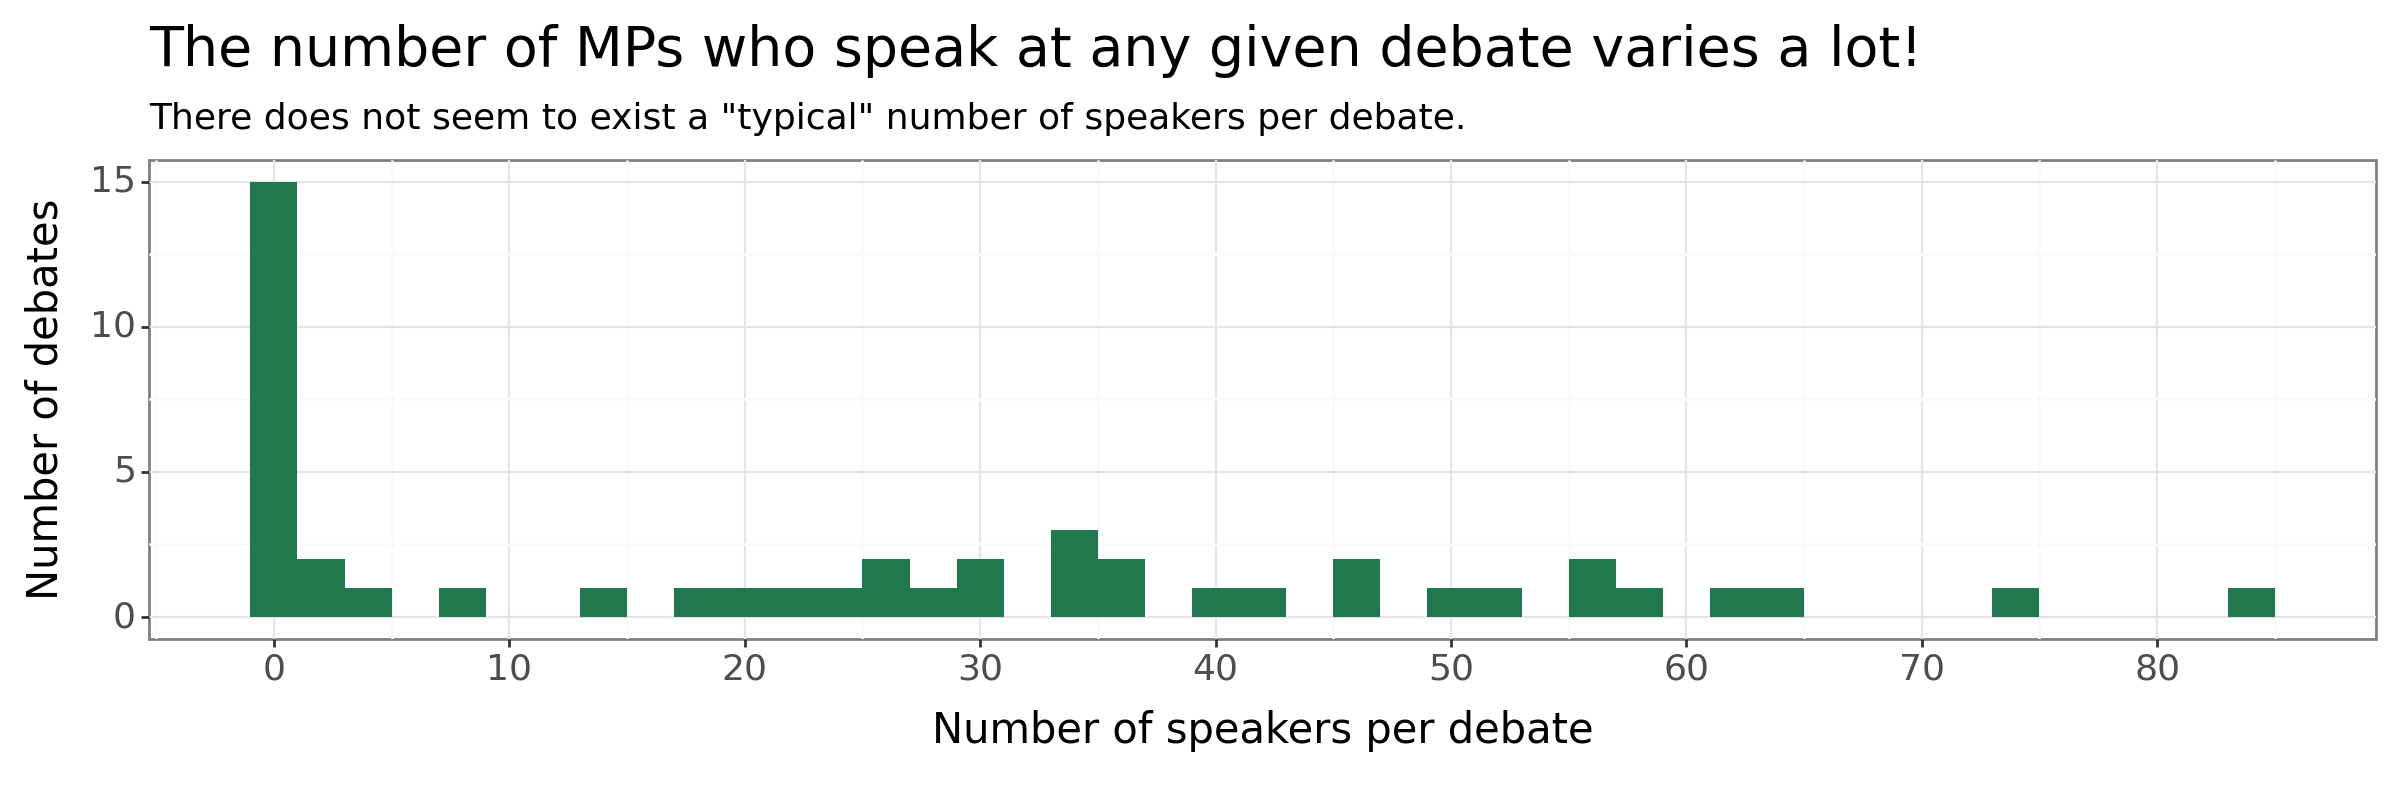

<Figure Size: (1200 x 400)>

In [61]:
g = (
    ggplot(speakers_per_debate, aes(x='num_speakers')) +
    geom_histogram(binwidth=2, fill='#20794D') +
    scale_x_continuous(breaks=range(0, 100, 10)) +
    labs(x='Number of speakers per debate', y='Number of debates',
         title='The number of MPs who speak at any given debate varies a lot!',
         subtitle='There does not seem to exist a "typical" number of speakers per debate.') +
    theme_bw() +
    theme(figure_size=(12, 4),
          text=element_text(size=13),
          axis_title=element_text(size=15),
          plot_title=element_text(size=20))
)

g

**Q:** Regardless of whether they spoke or not, how typical it is for an MP to dissent and vote against their party?

In [64]:
%%sql rebels_per_house_division <<

SELECT 
    main_mp_summary.party,
    main_mp_summary.house_division_id,
    SUM(main_mp_summary.voted_against_party) AS num_MP_votes_against_majority
FROM
(
    SELECT 
        main_mps.party,
        main_mps.debate_id,
        main_mps.house_division_id,
        main_mps.mp_id AS mp_id,
        CASE 
            WHEN SUM(main_mps.is_vote_aye == other_mps.is_vote_aye) < SUM(main_mps.is_vote_aye != other_mps.is_vote_aye) 
            THEN TRUE 
            ELSE FALSE 
        END AS voted_against_party
    FROM
        mp_votes main_mps
    LEFT JOIN 
        mp_votes other_mps
    ON 
        main_mps.house_division_id = other_mps.house_division_id AND 
        main_mps.mp_id != other_mps.mp_id AND 
        main_mps.party = other_mps.party
    GROUP BY
        main_mps.house_division_id,
        main_mps.mp_id
) main_mp_summary
GROUP BY
    main_mp_summary.party,
    main_mp_summary.house_division_id


Generating CTE with stored snippets: 'mp_votes', and 'mp_votes'

Running query in 'discordia'

In [66]:
rebels_per_house_division = rebels_per_house_division.DataFrame()

In [67]:
rebels_per_house_division

,party,house_division_id,num_MP_votes_against_majority
0,Alba,g1033.3,0
1,Alba,g1105.0,0
2,Alba,g131.5,0
3,Alba,g135.0,0
4,Alba,g140.0,0
...,...,...,...
519,Social Democratic and Labour Party,g840.0,0
520,Social Democratic and Labour Party,g850.0,0
521,Social Democratic and Labour Party,g869.0,0
522,Social Democratic and Labour Party,g900.3,0


**A small detour to collect a natural ordering of parties per size**

In [107]:
%%sql MPs_per_party <<

SELECT 
    party,
    COUNT(DISTINCT mp_id) AS num_MPs
FROM
    mp
WHERE
    term_start = 2017
GROUP BY
    party
ORDER BY
    num_MPs DESC

Running query in 'discordia'

In [108]:
MPs_per_party = MPs_per_party.DataFrame()

In [110]:
# I'm using this order in the plots
MPs_per_party

,party,num_MPs
0,Conservative,352
1,Labour,177
2,Scottish National Party,43
3,Labour/Co-operative,22
4,Liberal Democrat,15
5,Independent,15
6,DUP,8
7,Sinn Féin,7
8,Plaid Cymru,3
9,Social Democratic and Labour Party,2


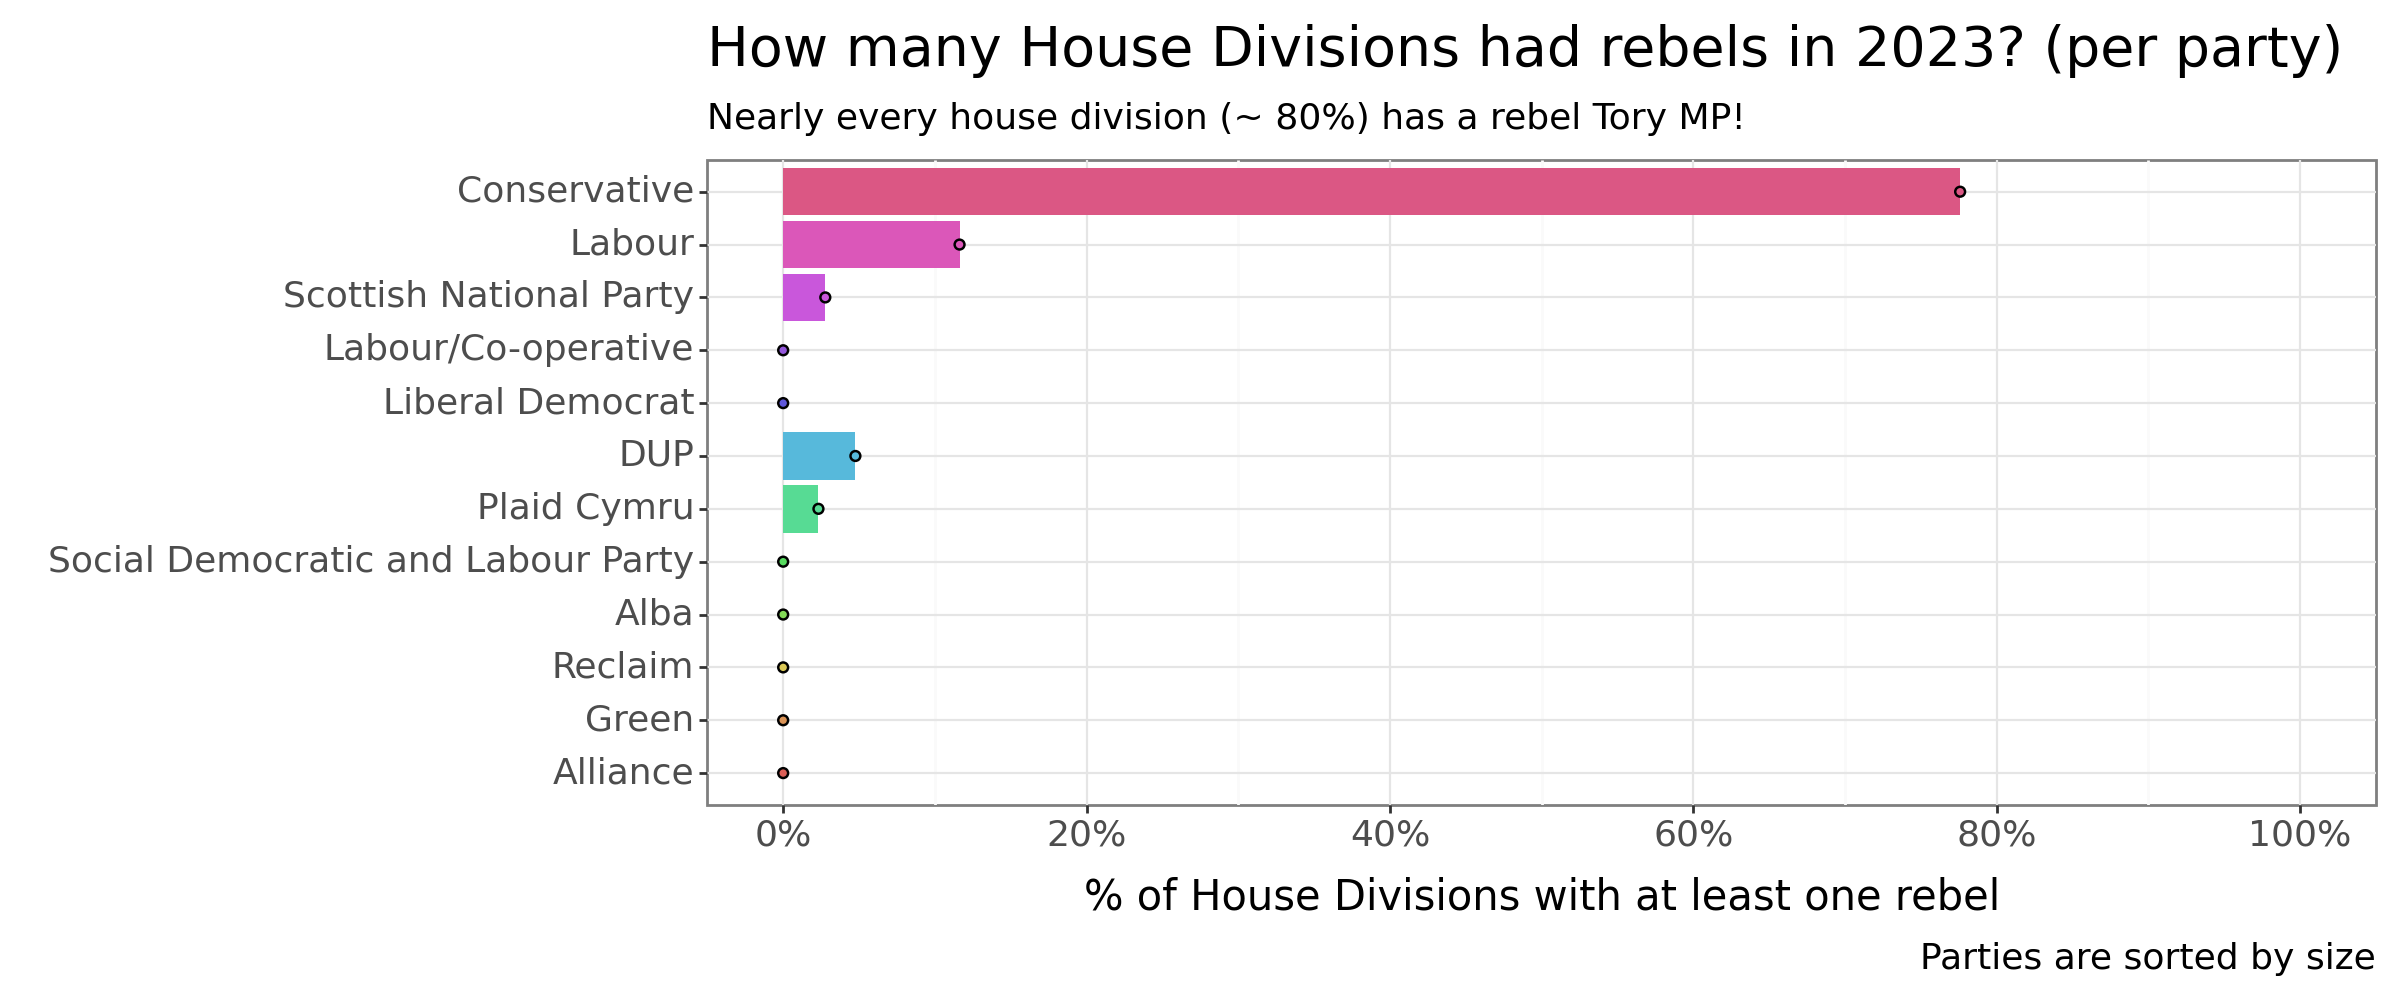

<Figure Size: (1200 x 500)>

In [123]:
plot_df = (
    rebels_per_house_division
        .groupby('party')
        .apply(lambda x: pd.Series({'num_votes': len(x), 'divisions_with_rebels': (x['num_MP_votes_against_majority'] > 0).sum()/len(x)}))
        .reset_index()
        .assign(party=lambda x: pd.Categorical(x['party'], categories=reversed(MPs_per_party['party'])))
)

g = (
    ggplot(plot_df.query('party != "Independent"'), 
           aes(x='party', y='divisions_with_rebels', fill='party')) +
    geom_col() +
    geom_point() +
    labs(x='', y='% of House Divisions with at least one rebel',
         title='How many House Divisions had rebels in 2023? (per party)',
         subtitle='Nearly every house division (~ 80%) has a rebel Tory MP!',
         caption='Parties are sorted by size') +
    scale_fill_discrete(name='Party', guide=None) +
    scale_y_continuous(labels=percent_format(), limits=[0, 1], breaks=np.arange(0, 1+0.1, 0.2)) +
    coord_flip() +
    theme_bw() +
    theme(figure_size=(12, 5),
          text=element_text(size=13),
          axis_title=element_text(size=15),
          plot_title=element_text(size=20))
)

g

**Q:** But how representative is the number of dissenters per session?

In [177]:
(
    rebels_per_house_division[rebels_per_house_division['num_MP_votes_against_majority'] > 0]
    # Order according to the order of the parties in the MPs_per_party DataFrame
    .assign(party=lambda x: pd.Categorical(x['party'], categories=[party for party in MPs_per_party['party'] if party in x['party'].unique()]))
    .groupby(['party'])['num_MP_votes_against_majority']
    .describe()
    .transpose()
)

C:\Users\Jon\AppData\Local\Temp\ipykernel_19100\3087637141.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


party,Conservative,Labour,Scottish National Party,Independent,DUP,Plaid Cymru
count,45.000000,5.000000,1.0,45.000000,2.0,1.0
mean,3.666667,2.000000,1.0,2.088889,2.0,1.0
std,5.942910,0.707107,NaN,1.104170,0.0,NaN
min,1.000000,1.000000,1.0,1.000000,2.0,1.0
25%,1.000000,2.000000,1.0,1.000000,2.0,1.0
50%,1.000000,2.000000,1.0,2.000000,2.0,1.0
75%,2.000000,2.000000,1.0,3.000000,2.0,1.0
max,29.000000,3.000000,1.0,6.000000,2.0,1.0


It's all very rare!

## 3.3 Who are the 'silent' rebels? 

In [153]:
%%sql discordia

SELECT 
    *
FROM
(
    SELECT
        party,
        mp_id,
        COUNT(DISTINCT house_division_id) AS num_divisions_voted,
        SUM(voted_against_party) AS num_votes_against_party,
        SUM(CASE WHEN num_speeches_debate > 0 THEN 1 ELSE 0 END) AS num_debates_spoken
    FROM
        votes_and_speeches
    GROUP BY
        party,
        mp_id
    ORDER BY
        party ASC,
        num_votes_against_party DESC
)
WHERE
    num_votes_against_party > 0 AND num_debates_spoken == 0

Generating CTE with stored snippets: 'votes_and_speeches'

party,mp_id,num_divisions_voted,num_votes_against_party,num_debates_spoken
Conservative,25276,35,27,0
Conservative,10580,54,4,0
Conservative,10103,42,4,0
Conservative,25350,44,3,0
Conservative,24888,23,3,0
Conservative,11661,55,3,0
Conservative,25431,22,2,0
Conservative,24870,51,2,0
Conservative,24860,26,2,0
Conservative,11785,46,2,0


**Automate the process of getting the voting record of a given MP**

I copied the SQL query I used to extract Lisa Cameron's voting record and placed it in the file `src/sql/vote_record.sql`. SQLite doesn't have prepared statements, so I will just read the file into a string and replace the name of the MP with the name of the MP I want to investigate.

In [154]:
# Read text file ./src/vote_record.sql
with open('./../src/sql/vote_record.sql', 'r') as f:
    vote_record_sql = f.read()

vote_record_sql

'SELECT \n    house_divisions.debate_id,\n    main_mp.house_division_id,\n    COALESCE(num_utterances.num_utterances, 0) AS \'num_utterances\',\n    CASE WHEN main_mp.is_vote_aye = 1 THEN \'aye\' ELSE \'no\' END AS \'The MP voted:\',\n    SUM(CASE WHEN other_mps.is_vote_aye = 1 THEN 1 ELSE 0 END) AS \'# fellow MPs voting aye:\',\n    SUM(CASE WHEN other_mps.is_vote_aye = 0 THEN 1 ELSE 0 END) AS \'# fellow MPs voting no:\',\n    CASE WHEN SUM(main_mp.is_vote_aye != other_mps.is_vote_aye) > SUM(main_mp.is_vote_aye = other_mps.is_vote_aye) THEN \'AGAINST\' ELSE \'WITH \' END AS \'Were they in the majority:\'\nFROM\n    (SELECT \n        mp.mp_id,\n        mp.party,\n        votes.house_division_id,\n        votes.is_vote_aye\n     FROM\n        votes\n     LEFT JOIN\n         mp\n     USING(mp_id)\n     WHERE votes.mp_id = "?" AND mp.term_start == 2017) main_mp\nLEFT OUTER JOIN\n    (SELECT\n        votes.house_division_id,\n        votes.is_vote_aye,\n        mp.party\n     FROM\n       

Test that it works:

In [159]:
# Lisa Cameron's vote record
pd.read_sql(vote_record_sql.replace("?", "25276"), engine)

,debate_id,house_division_id,num_utterances,The MP voted:,# fellow MPs voting aye:,# fellow MPs voting no:,Were they in the majority:
0,2023-01-11e.566.1,g613.0,0,aye,0,302,AGAINST
1,2023-01-16f.139.0,g140.0,0,no,303,0,AGAINST
2,2023-01-16f.144.0,g144.2,0,no,301,0,AGAINST
3,2023-01-16f.54.0,g135.0,0,no,307,1,AGAINST
4,2023-01-16f.54.0,g131.5,0,aye,1,298,AGAINST
5,2023-01-17c.228.0,g262.0,0,no,310,0,AGAINST
6,2023-01-31b.278.0,g308.0,0,aye,0,297,AGAINST
7,2023-02-21c.193.0,g194.6,0,no,252,0,AGAINST
8,2023-02-28d.701.0,g710.0,0,aye,0,0,WITH
9,2023-03-13b.573.0,g647.0,0,no,308,0,AGAINST


# Part 4: Investigate individual cases

## 4.1 Desmond Swayne (Conservative, `mp_id="10580"`)

In [160]:
%%sql discordia

SELECT 
    *
FROM
    mp
WHERE
    mp.mp_id == "10580"

mp_id,first_name,last_name,party,constituency,url,term_start,term_end
10580,Desmond,Swayne,Conservative,New Forest West,https://www.theyworkforyou.com/mp/10580/desmond_swayne/new_forest_west,2001,2005
10580,Desmond,Swayne,Conservative,New Forest West,https://www.theyworkforyou.com/mp/10580/desmond_swayne/new_forest_west,2005,2010
10580,Desmond,Swayne,Conservative,New Forest West,https://www.theyworkforyou.com/mp/10580/desmond_swayne/new_forest_west,2010,1015
10580,Desmond,Swayne,Conservative,New Forest West,https://www.theyworkforyou.com/mp/10580/desmond_swayne/new_forest_west,2015,2017
10580,Desmond,Swayne,Conservative,New Forest West,https://www.theyworkforyou.com/mp/10580/desmond_swayne/new_forest_west,2017,2023


In [161]:
pd.read_sql(vote_record_sql.replace("?", "10580"), engine)

,debate_id,house_division_id,num_utterances,The MP voted:,# fellow MPs voting aye:,# fellow MPs voting no:,Were they in the majority:
0,2023-01-11e.566.1,g613.0,0,no,1,301,WITH
1,2023-01-11e.618.0,g673.0,0,no,0,295,WITH
2,2023-01-11e.618.0,g676.0,0,aye,287,2,WITH
3,2023-01-16f.139.0,g140.0,0,aye,302,1,WITH
4,2023-01-16f.144.0,g144.2,0,aye,300,1,WITH
5,2023-01-16f.54.0,g135.0,0,aye,306,2,WITH
6,2023-01-17c.228.0,g262.0,0,aye,309,1,WITH
7,2023-01-31b.221.1,g270.1,0,no,0,304,WITH
8,2023-01-31b.221.1,g274.2,0,aye,301,1,WITH
9,2023-01-31b.278.0,g308.0,0,no,1,296,WITH


**What are some instances of debates in which he spoke?**

In [11]:
%%sql selected_speeches <<

SELECT 
    debates.url,
    speeches.debate_id,
    speeches.speech_id
FROM
    speeches
LEFT JOIN
    debates
USING(debate_id)
WHERE
    speaker_id = "10580"
ORDER BY 
    debate_id ASC

Running query in 'discordia'

In [12]:
df_selected_speeches = selected_speeches.DataFrame()

In [14]:
df_selected_speeches.set_index('url')

,debate_id,speech_id
url,,
https://www.theyworkforyou.com/debates/?id=2023-01-09b.316.0,2023-01-09b.316.0,g327.2
https://www.theyworkforyou.com/debates/?id=2023-01-19b.512.3,2023-01-19b.512.3,g514.0
https://www.theyworkforyou.com/debates/?id=2023-01-24c.878.0,2023-01-24c.878.0,g882.2
https://www.theyworkforyou.com/debates/?id=2023-01-26b.1167.5,2023-01-26b.1167.5,g1167.6
https://www.theyworkforyou.com/debates/?id=2023-01-26b.1167.5,2023-01-26b.1167.5,g1167.8
...,...,...
https://www.theyworkforyou.com/debates/?id=2023-11-15b.643.1,2023-11-15b.643.1,g645.1
https://www.theyworkforyou.com/debates/?id=2023-11-21a.182.3,2023-11-21a.182.3,g182.4
https://www.theyworkforyou.com/debates/?id=2023-11-21a.182.3,2023-11-21a.182.3,g182.6


# Part 5: Extract motions (the object of the debate)

In [189]:
%%sql testing <<

SELECT 
    speeches.*,
    debates.url
FROM
    speeches
RIGHT JOIN
    house_divisions
USING(debate_id)
LEFT JOIN
    debates
USING(debate_id)


Running query in 'discordia'

In [190]:
testing = testing.DataFrame()

In [197]:
testing.groupby(['debate_id']).first()[['url', 'speech_raw_text']].reset_index().set_index(['url'])

,debate_id,speech_raw_text
url,,
https://www.theyworkforyou.com/debates/?id=2023-01-11e.566.1,2023-01-11e.566.1,"I beg to move,\n\nThat the following Standing ..."
https://www.theyworkforyou.com/debates/?id=2023-01-11e.618.0,2023-01-11e.618.0,"I inform the House that amendment (a), tabled ..."
https://www.theyworkforyou.com/debates/?id=2023-01-16f.139.0,2023-01-16f.139.0,None
https://www.theyworkforyou.com/debates/?id=2023-01-16f.144.0,2023-01-16f.144.0,None
https://www.theyworkforyou.com/debates/?id=2023-01-16f.54.0,2023-01-16f.54.0,I must inform the House that the reasoned amen...
https://www.theyworkforyou.com/debates/?id=2023-01-17c.228.0,2023-01-17c.228.0,"I beg to move,\n\nThat this House has consider..."
https://www.theyworkforyou.com/debates/?id=2023-01-31b.221.1,2023-01-31b.221.1,I advise the House that Mr. Speaker has select...
https://www.theyworkforyou.com/debates/?id=2023-01-31b.278.0,2023-01-31b.278.0,"I remind everybody here that, if you participa..."
https://www.theyworkforyou.com/debates/?id=2023-02-21c.193.0,2023-02-21c.193.0,I congratulate the Chair of the Selection Comm...


#TODO: It's not clear yet how to proceed with the extraction of motion

---

# Part 6: Quantitative text analysis of the debates

I will select the debates in which the politician above spoke and analyse the text of the debates. 

In [19]:
%%sql selected_speeches <<

SELECT 
    debates.url,
    speeches.debate_id,
    speeches.speech_id,
    speech_raw_text,
    speech_html
FROM
    speeches
LEFT JOIN
    debates
USING(debate_id)
WHERE
    speaker_id = "10580"
ORDER BY 
    debate_id ASC

Running query in 'discordia'

In [20]:
df_selected_speeches = selected_speeches.DataFrame()

In [23]:
df_selected_speeches

,url,debate_id,speech_id,speech_raw_text,speech_html
0,https://www.theyworkforyou.com/debates/?id=202...,2023-01-09b.316.0,g327.2,Has any analysis been made available to Minist...,"<p pid=""b327.2/1"">\n Has any analysis been mad..."
1,https://www.theyworkforyou.com/debates/?id=202...,2023-01-19b.512.3,g514.0,When will services be restored on the mainline...,"<p pid=""b514.0/1"">\n When will services be res..."
2,https://www.theyworkforyou.com/debates/?id=202...,2023-01-24c.878.0,g882.2,Having been the Government Whip on the Equal M...,"<p pid=""c882.2/1"">\n Having been the Governmen..."
3,https://www.theyworkforyou.com/debates/?id=202...,2023-01-26b.1167.5,g1167.6,Whether the commissioners have made an estimat...,"<p pid=""b1167.6/1"" qnum=""903294"">\n Whether th..."
4,https://www.theyworkforyou.com/debates/?id=202...,2023-01-26b.1167.5,g1167.8,Can my hon. Friend assure me that the not disp...,"<p pid=""b1167.8/1"">\n Can my hon. Friend assur..."
...,...,...,...,...,...
82,https://www.theyworkforyou.com/debates/?id=202...,2023-11-15b.643.1,g645.1,"If a two-state solution is to have a chance, H...","<p pid=""b645.1/1"" qnum=""900083"">\n If a two-st..."
83,https://www.theyworkforyou.com/debates/?id=202...,2023-11-21a.182.3,g182.4,Whether he is taking steps to increase levels ...,"<p pid=""a182.4/1"" qnum=""900207"">\n Whether he ..."
84,https://www.theyworkforyou.com/debates/?id=202...,2023-11-21a.182.3,g182.6,It is essential that every advantage be had fr...,"<p pid=""a182.6/1"">\n It is essential that ever..."
85,https://www.theyworkforyou.com/debates/?id=202...,2023-11-27a.546.4,g548.0,Is the Home Secretary doing enough to reassure...,"<p pid=""a548.0/1"" qnum=""900310"">\n Is the Home..."


## 6.1 Installation

You have to install spacy and then download the English model. I am downloading the large model because I want to use the word vectors.

```bash
python -m spacy download en_core_web_lg
```

In [78]:
import spacy

from spacy import displacy

nlp = spacy.load('en_core_web_lg')

## 6.2. Tokenisation

In [47]:
df_selected_speeches['speech_raw_text'].iloc[0]

'Has any analysis been made available to Ministers regarding the movements in wholesale prices and the tariffs actually being offered to customers going forward?'

In [75]:
doc = nlp(df_selected_speeches['speech_raw_text'].iloc[0])
type(doc)

spacy.tokens.doc.Doc

**Dependencies**

In [79]:
displacy.render(doc, style='dep', jupyter=True)

**Linguistic annotation**

In [70]:
# Once you run spacy on a text, you have access to several attributes per token
[(token.text, token.pos_) for token in doc]

[('Has', 'AUX'),
 ('any', 'DET'),
 ('analysis', 'NOUN'),
 ('been', 'AUX'),
 ('made', 'VERB'),
 ('available', 'ADJ'),
 ('to', 'ADP'),
 ('Ministers', 'NOUN'),
 ('regarding', 'VERB'),
 ('the', 'DET'),
 ('movements', 'NOUN'),
 ('in', 'ADP'),
 ('wholesale', 'ADJ'),
 ('prices', 'NOUN'),
 ('and', 'CCONJ'),
 ('the', 'DET'),
 ('tariffs', 'NOUN'),
 ('actually', 'ADV'),
 ('being', 'AUX'),
 ('offered', 'VERB'),
 ('to', 'ADP'),
 ('customers', 'NOUN'),
 ('going', 'VERB'),
 ('forward', 'ADV'),
 ('?', 'PUNCT')]

**What are the Named Entities that this language model can recognise?**

In [84]:
df_selected_speeches['speech_raw_text'].apply(lambda x: list(nlp(x).ents))

0                                                    []
1                           [(Waterloo), (Southampton)]
2     [(the, Equal, Marriage, (, Same, Sex, Couples)...
3                                            [(Church)]
4                                   [(£, 100, million)]
                            ...                        
82              [(two), (Hamas), (first), (west, bank)]
83                                                   []
84                                                   []
85             [(Home), (Jews), (the, United, Kingdom)]
86                                                   []
Name: speech_raw_text, Length: 87, dtype: object

In [97]:
displacy.render(nlp(df_selected_speeches['speech_raw_text'].iloc[1]), style='ent', jupyter=True)

In [96]:
spacy.explain('GPE')

'Nationalities or religious or political groups'

## 6.3 Similarity between two documents


In [105]:
doc1 = nlp(df_selected_speeches['speech_raw_text'].iloc[0])

doc2 = nlp(df_selected_speeches['speech_raw_text'].iloc[4])

doc1.similarity(doc2)

0.8821052046670113

**Q:** How do all speeches of a given MP compare to each other?

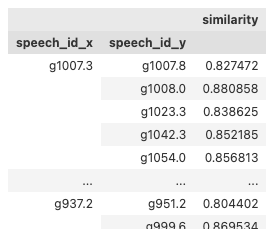

⚠️ **WARNING:** Don't take similarity results at face value. See the following text from the [spaCy documentation](https://spacy.io/usage/spacy-101#similarity-expectations):

<div style="margin-left:1em; width: 50%; border-left: 5px solid #ccc; padding-left: 1em;">

Computing similarity scores can be helpful in many situations, but it’s also important to maintain **realistic expectations** about what information it can provide. Words can be related to each other in many ways, so a single “similarity” score will always be a **mix of different signals**, and vectors trained on different data can produce very different results that may not be useful for your purpose. Here are some important considerations to keep in mind:

- There’s no objective definition of similarity. Whether “I like burgers” and “I like pasta” is similar **depends on your application**. Both talk about food preferences, which makes them very similar – but if you’re analyzing mentions of food, those sentences are pretty dissimilar, because they talk about very different foods.

- The similarity of [Doc](https://spacy.io/api/doc) and [Span](https://spacy.io/api/span) objects defaults to the **average** of the token vectors. This means that the vector for “fast food” is the average of the vectors for “fast” and “food”, which isn’t necessarily representative of the phrase “fast food”.

- Vector averaging means that the vector of multiple tokens is insensitive to the order of the words. Two documents expressing the same meaning with dissimilar wording will return a lower similarity score than two documents that happen to contain the same words while expressing different meanings.

</div>

## 6.4 Topic modelling with BERTopic


In [234]:
from bertopic import BERTopic

nlp = spacy.load('en_core_web_lg', exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])

from sklearn.feature_extraction.text import TfidfVectorizer

my_stopwords = list(nlp.Defaults.stop_words) + ['estimate', 'hon', 'implement', 'opportunity', 'plan', 'paragraph', 'sir', 'minister', 'told', 'right', 'good', 'speaker', 'mr speaker']

vectorizer_model = TfidfVectorizer(stop_words=my_stopwords, ngram_range=(1,2))

topic_model = BERTopic(embedding_model=nlp, vectorizer_model=vectorizer_model, top_n_words=10, min_topic_size=3, n_gram_range=(1,2))
topics, probs = topic_model.fit_transform(df_selected_speeches['speech_raw_text'].tolist())

fig = topic_model.visualize_topics()
fig.show()

/Users/jon/miniconda3/envs/venv-commons/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'mr', 've'] not in stop_words.

/Users/jon/miniconda3/envs/venv-commons/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [235]:
topic_model.get_topic(0)

[('plans', 0.027470027198906687),
 ('trade', 0.024210770548060357),
 ('sector', 0.024210770548060357),
 ('customers', 0.024210770548060357),
 ('realistic', 0.024210770548060357),
 ('barriers', 0.024210770548060357),
 ('pension', 0.024210770548060357),
 ('energy', 0.024210770548060357),
 ('services', 0.024210770548060357),
 ('mask', 0.024210770548060357)]

In [236]:
df_topics = topic_model.get_document_info(df_selected_speeches['speech_raw_text'].tolist())
df_topics.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Has any analysis been made available to Minist...,0,0_plans_trade_sector_customers,"[plans, trade, sector, customers, realistic, b...",[How are we going to get vital private sector ...,plans - trade - sector - customers - realistic...,0.874298,False
1,When will services be restored on the mainline...,0,0_plans_trade_sector_customers,"[plans, trade, sector, customers, realistic, b...",[How are we going to get vital private sector ...,plans - trade - sector - customers - realistic...,1.000000,False
2,Having been the Government Whip on the Equal M...,-1,-1_motion_level_government_bill,"[motion, level, government, bill, announced, p...","[The substantive part of the motion, paragraph...",motion - level - government - bill - announced...,0.000000,False
3,Whether the commissioners have made an estimat...,2,2_england_recent_discussions_section,"[england, recent, discussions, section, bank e...",[What discussions the Church of England has ha...,england - recent - discussions - section - ban...,0.917205,False
4,Can my hon. Friend assure me that the not disp...,0,0_plans_trade_sector_customers,"[plans, trade, sector, customers, realistic, b...",[How are we going to get vital private sector ...,plans - trade - sector - customers - realistic...,1.000000,False


In [238]:
df_topics[df_topics['Topic'] == 1][['Document', 'Top_n_words']].set_index('Document')

,Top_n_words
Document,
"Thank you, Mr. Speaker, for making it absolutely clear that this man is not getting in here, even if the Minister is going to give him space in the office. But I ask you this, Sir: is not the very fact that an announcement of his intention to travel has been made—in the language habitual to the Government of China—“a provocation”?",cat - fired boilers - administration - misunde...
"If habitats can be restored to a quality in which reptiles—in particular the smooth snake—can thrive, that will be good for all wildlife. That would be a good target, would it not?",cat - fired boilers - administration - misunde...
"What does it do for a respected profession that, when one visits a hospital, one is confronted by a rabble chanting like a schump of rudies, particularly when they have not co-operated with hospital authorities to minimise the impact of their absence?",cat - fired boilers - administration - misunde...
"There has clearly been a misunderstanding, despite the police doing a brilliant job, and that is why there has been an apology. But would the Minister not expect that misunderstanding to have been resolved well within the 16 hours for which the six were incarcerated? Surely there should be some questions asked about that.",cat - fired boilers - administration - misunde...
"This tragedy would not have occurred had there been a requirement for a face-to-face consultation and clinical administration of the drugs, would it?",cat - fired boilers - administration - misunde...
"Pupils have been denounced as “despicable” for failing to accept the reality of a fellow pupil who identified as a cat. May we have a debate on Confucius, for it was he who observed that the most difficult thing is to search a dark room for a black cat, particularly when there is no cat?",cat - fired boilers - administration - misunde...
"This is an excellent package, but one way to ensure that investment flows to productive enterprise is to prevent it from being crowded out by growing Government debt, isn’t it?",cat - fired boilers - administration - misunde...
"The Minister has lifted a blight from my constituency, but as a result of these measures we are all going to be swimming in cleaner water as well, aren’t we?",cat - fired boilers - administration - misunde...
"Absolutely, Mr Speaker. There is a panic now in Germany as its premature ban on gas-fired boilers approaches. The Minister will want to avoid a similar panic as we approach our own premature ban on oil-fired boilers, won’t he?",cat - fired boilers - administration - misunde...


NOTE: This notebook is a WIP